In [30]:
import requests
import pandas as pd
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

In [31]:
pip install networkx matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
pip install torch torch-geometric pandas scikit-learn


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Parameters
CONCEPT_ID = "C41008148"  # Computer Science with english filter
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"
MAX_PAPERS = 500
PER_PAGE = 50

In [34]:
# Storage
author_data = defaultdict(lambda: {"display_name": "", "institution": "", "publication_count": 0, "citation_count": 0})
coauthor_edges = set()
print("Fetching data from OpenAlex...")

Fetching data from OpenAlex...


In [35]:
cursor = "*"
fetched_papers = 0

while fetched_papers < MAX_PAPERS:
    url = "https://api.openalex.org/works"
    params = {
        "filter": f"concepts.id:{CONCEPT_ID},from_publication_date:{START_DATE},to_publication_date:{END_DATE},language:en",
        "per-page": PER_PAGE,
        "cursor": cursor,
    }

    response = requests.get(url, params=params)
    data = response.json()
    results = data.get('results', [])
    
    for work in results:
        if 'authorships' not in work:
            continue

        authors = work['authorships']
        author_ids = []

        for author in authors:
            author_id = author['author']['id']
            if not author_id:
                continue
            author_ids.append(author_id)
            
            display_name = author['author']['display_name']
            institution = author['institutions'][0]['display_name'] if author['institutions'] else "Unknown"
            citations = work.get("cited_by_count", 0)

            entry = author_data[author_id]
            entry["display_name"] = display_name
            entry["institution"] = institution
            entry["publication_count"] += 1
            entry["citation_count"] += citations

        # Add co-authorship edges
        for i in range(len(author_ids)):
            for j in range(i + 1, len(author_ids)):
                edge = tuple(sorted((author_ids[i], author_ids[j])))
                coauthor_edges.add(edge)

        fetched_papers += 1
        if fetched_papers >= MAX_PAPERS:
            break

    cursor = data['meta']['next_cursor']
    time.sleep(1) 

print(f"Fetched {fetched_papers} papers.")

# Select top authors by publication count
sorted_authors = sorted(author_data.items(), key=lambda x: x[1]['publication_count'], reverse=True)[:300]
selected_ids = set([aid for aid, _ in sorted_authors])

# Prepare nodes.csv
nodes = []
for author_id, info in sorted_authors:
    nodes.append({
        "author_id": author_id,
        "display_name": info["display_name"],
        "institution": info["institution"],
        "publication_count": info["publication_count"],
        "citation_count": info["citation_count"]
    })

df_nodes = pd.DataFrame(nodes)
df_nodes.to_csv("nodes.csv", index=False)
print("Saved nodes.csv")

# Prepare edges.csv
edges = []
for source, target in coauthor_edges:
    if source in selected_ids and target in selected_ids:
        edges.append({"source_author_id": source, "target_author_id": target})

Fetched 500 papers.
Saved nodes.csv


In [36]:
df_edges = pd.DataFrame(edges)
df_edges.to_csv("edges.csv", index=False)
print("Saved edges.csv")

Saved edges.csv


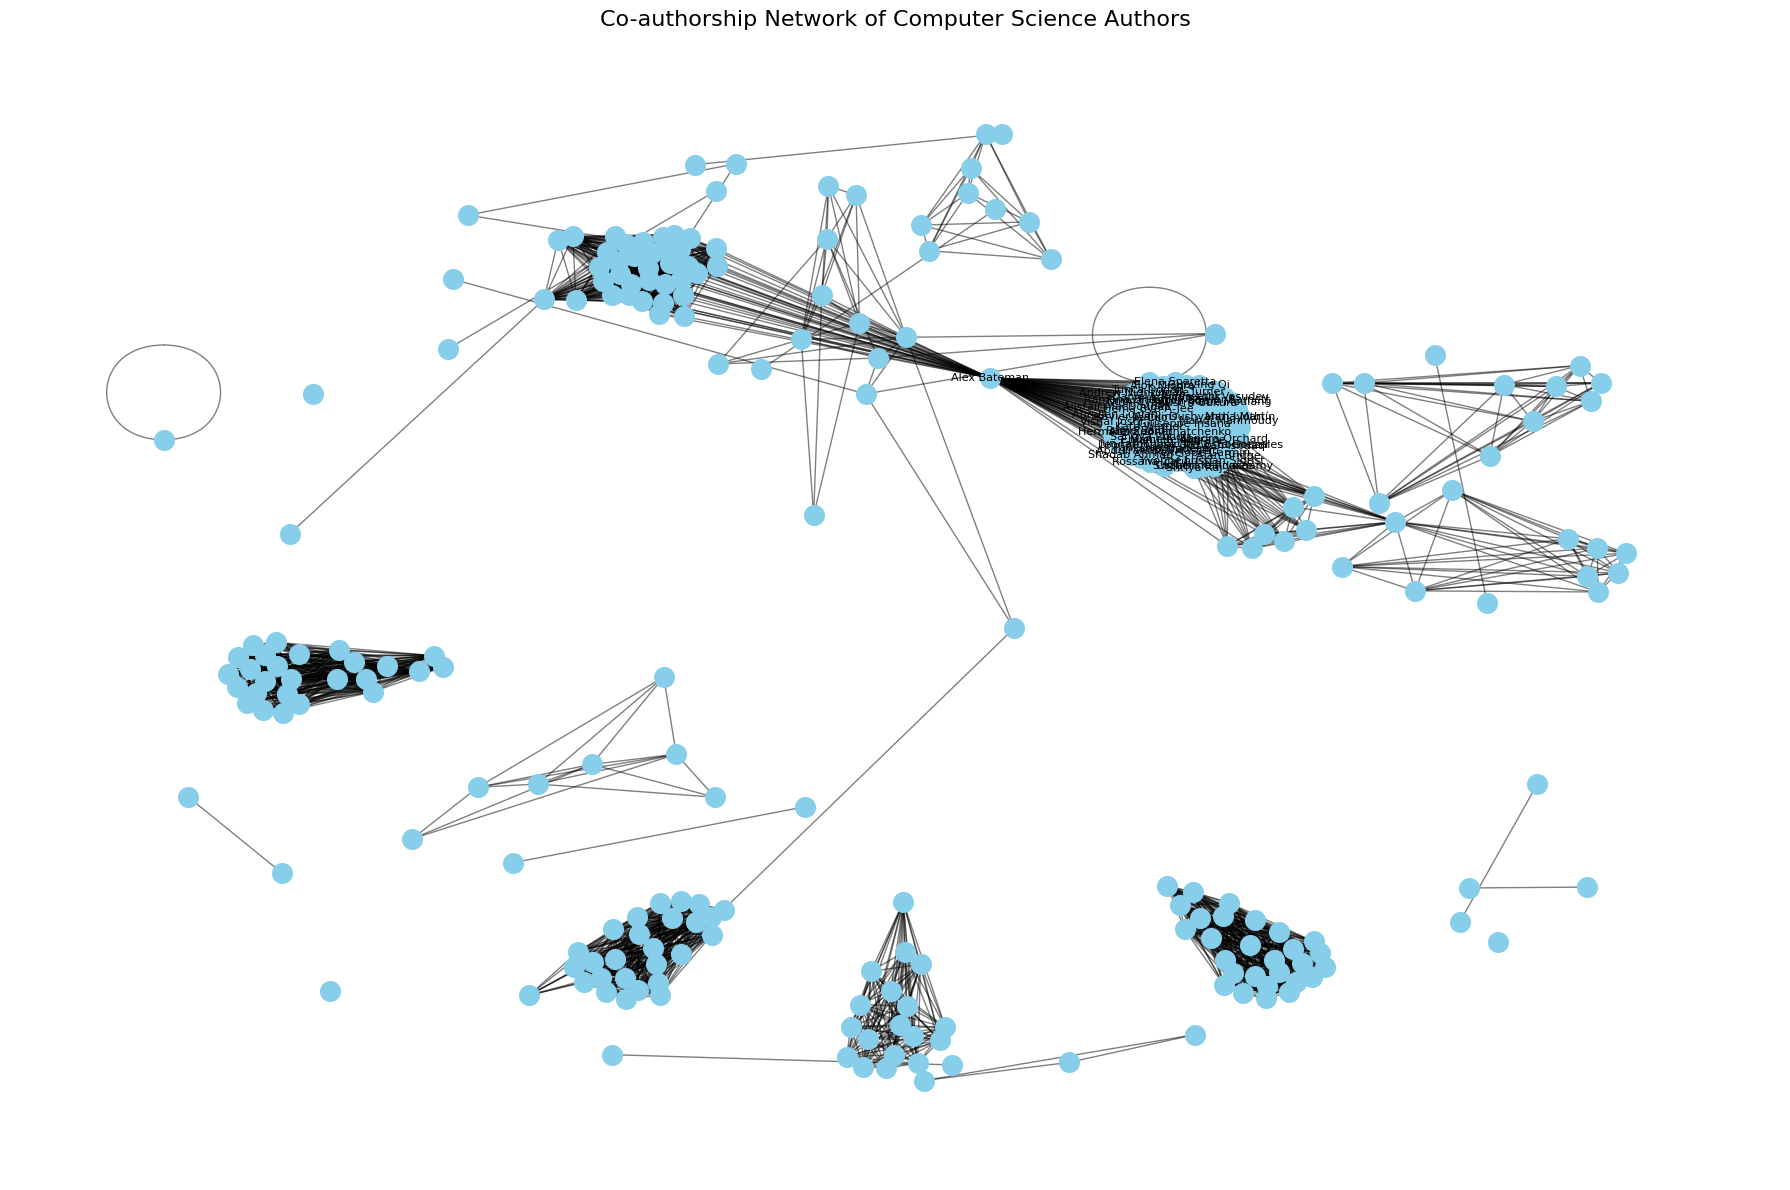

In [37]:
# Load data
nodes_df = pd.read_csv("nodes.csv")
edges_df = pd.read_csv("edges.csv")

# Initialize graph
G = nx.Graph()

# nodes with labels
for _, row in nodes_df.iterrows():
    G.add_node(row['author_id'], label=row['display_name'])

# edges
for _, row in edges_df.iterrows():
    G.add_edge(row['source_author_id'], row['target_author_id'])

# graph
plt.figure(figsize=(18, 12))

# Use spring layout for better spacing
pos = nx.spring_layout(G, seed=42, k=0.3)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=200)

# edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# labels
degree_dict = dict(G.degree)
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:50]
top_node_ids = [node_id for node_id, _ in top_nodes]

labels = {node: G.nodes[node]['label'] for node in top_node_ids}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Co-authorship Network of Computer Science Authors", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.savefig("author_graph.png", dpi=300)
plt.show()